### Fast.ai Training Loop

Attempt the third week of this course with Fast.ai instead.  See if it simplifies learning on less data and gets better results. 

* Example of working with overhead data - https://github.com/fastai/fastai/blob/master/dev_nbs/course/lesson3-planet.ipynb
* Working with existing pytorch code - https://docs.fast.ai/migrating_pytorch
* MNIST with Fast.ai - https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson7-resnet-mnist.ipynb

#### Next Steps

* These images are really small.  32x32x3. Most similar to MNIST. What does that network look like? Should you consider a very simple network?
* Try data augmentation? 


In [1]:
url = 'https://liveproject-resources.s3.amazonaws.com/other/MelanomaDetection.zip'
pth = './data/MelanomaDetection.zip'
unp = './data/MelanomaDetection'
bs  = 24

In [2]:
import os

In [3]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'


In [4]:
from fastai.vision.all import *
from fastai.data.all import *
from fastai.callback.all import *

In [5]:
import torch
import torchvision
from sklearn.model_selection import train_test_split
from torch.nn import BCELoss, BCEWithLogitsLoss, CrossEntropyLoss #not sure which I'd like to use. 
from torch.nn import Linear
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader, Subset, SubsetRandomSampler
from torch.optim.lr_scheduler import CyclicLR, OneCycleLR

import numpy as np

In [6]:
%load_ext autoreload
%autoreload 2

from utils import *

In [7]:
print(torch.cuda.device_count())
torch.cuda.is_available()

2


True

In [8]:
labeledSet = MILabeled(unp + '/labeled', ToTensor())

sd = 43
cs = len(labeledSet)
ci = range(0, cs)
train_idxs, test_idxs = train_test_split(ci, random_state=sd, train_size=0.75)

train_sampler = SubsetRandomSampler(train_idxs) #subset would work just fine here too I think. 
test_sampler  = SubsetRandomSampler(test_idxs)


In [16]:
labeled_ds = MILabeled(unp + '/labeled', ToTensor())
train_dl = DataLoader(labeled_ds, batch_size=bs, sampler=train_sampler)
test_dl = DataLoader(labeled_ds, batch_size=bs, sampler=test_sampler)

In [8]:
data = DataLoaders(train_dl, test_dl)

In [22]:
learn = cnn_learner(data, resnet34, metrics=error_rate, n_out=2)

### LEFT OFF HERE. PROBABLY SIMPLER TO JUST USE FASTAI DATALOADERS.
#
# 

AttributeError: 'DataLoader' object has no attribute 'after_batch'

In [6]:
#I couldn't get this to work with CUDA. Let's try it without. 

#default_device(use_cuda=False)


#try the second gpu I have. This often fails
#torch.cuda.set_device('cuda:1')
#default_device(use_cuda=True)

### FastAi Vision Data loader


In [9]:
path  = unp + '/labeled'
files = get_image_files(path)
dls = ImageDataLoaders.from_name_re(path, files, r'\w+_([01]).jpg')  #Note: you can explicity set the device here too. 

In [10]:
dls.one_batch()

(TensorImage([[[[0.7529, 0.7686, 0.7882,  ..., 0.8353, 0.8196, 0.8118],
           [0.7608, 0.7765, 0.8039,  ..., 0.8431, 0.8235, 0.8196],
           [0.7804, 0.7961, 0.8196,  ..., 0.8510, 0.8392, 0.8314],
           ...,
           [0.7765, 0.7843, 0.7922,  ..., 0.7961, 0.7882, 0.7765],
           [0.7647, 0.7765, 0.7843,  ..., 0.7882, 0.7804, 0.7725],
           [0.7647, 0.7686, 0.7804,  ..., 0.7843, 0.7804, 0.7765]],
 
          [[0.7333, 0.7490, 0.7608,  ..., 0.7725, 0.7647, 0.7569],
           [0.7412, 0.7529, 0.7647,  ..., 0.7804, 0.7686, 0.7647],
           [0.7451, 0.7608, 0.7765,  ..., 0.7882, 0.7765, 0.7686],
           ...,
           [0.6745, 0.6824, 0.6902,  ..., 0.7176, 0.7098, 0.7059],
           [0.6627, 0.6745, 0.6824,  ..., 0.7098, 0.7098, 0.7020],
           [0.6549, 0.6667, 0.6784,  ..., 0.7059, 0.7098, 0.7059]],
 
          [[0.7490, 0.7647, 0.7882,  ..., 0.8235, 0.8157, 0.8078],
           [0.7569, 0.7686, 0.7961,  ..., 0.8235, 0.8196, 0.8157],
           [0.7647,

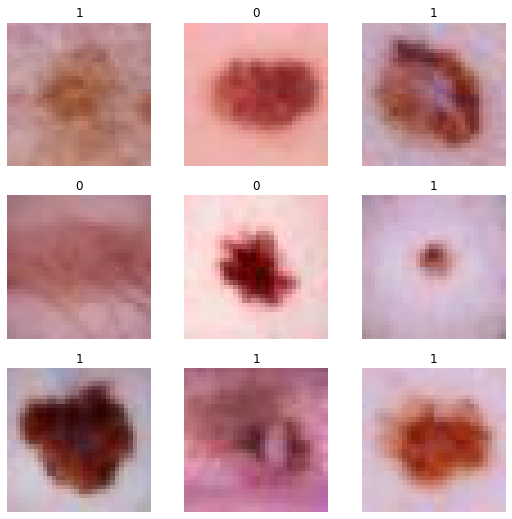

In [11]:
dls.show_batch()

In [12]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=1.3182567499825382e-06)

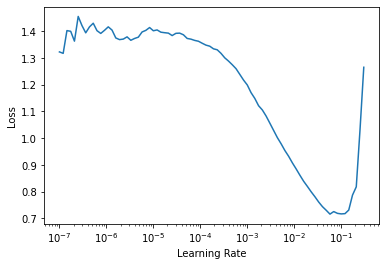

In [13]:
learn.lr_find()

In [12]:
learn.fine_tune(4, 2e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.188049,1.036879,0.350000,00:00


epoch,train_loss,valid_loss,error_rate,time
0,0.811810,0.883642,0.350000,00:00
1,0.742546,0.670185,0.325000,00:00
2,0.602157,0.624921,0.325000,00:00
3,0.571978,0.542548,0.250000,00:00


In [13]:
learn.fine_tune(10, 2e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.415673,0.435128,0.225000,00:00


epoch,train_loss,valid_loss,error_rate,time
0,0.347689,0.426963,0.200000,00:00
1,0.304941,0.443181,0.200000,00:00
2,0.291017,0.471546,0.200000,00:00
3,0.269005,0.456469,0.200000,00:00
4,0.235528,0.403307,0.200000,00:00
5,0.208878,0.378820,0.175000,00:00
6,0.190758,0.382477,0.175000,00:00
7,0.174984,0.388995,0.175000,00:00
8,0.162307,0.417355,0.175000,00:00
9,0.145503,0.430744,0.150000,00:00


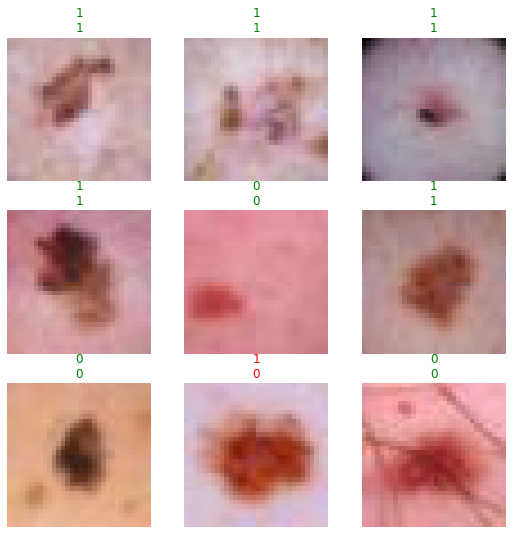

In [14]:
learn.show_results()

### Data Augmentation

In [17]:
a_tfms = aug_transforms(mult=1.0, do_flip=True, 
                        flip_vert=True, max_rotate=10.0, 
                        min_zoom=1.0, max_zoom=1.05, 
                        max_lighting=0.2, max_warp=0, 
                        p_affine=0.75, p_lighting=0.75, 
                        xtra_tfms=None, 
                        size=None, mode='bilinear', 
                        pad_mode='reflection', align_corners=True, 
                        batch=False, min_scale=1.0)

dls_aug = ImageDataLoaders.from_name_re(path, files, r'\w+_([01]).jpg', batch_tfms=a_tfms) 

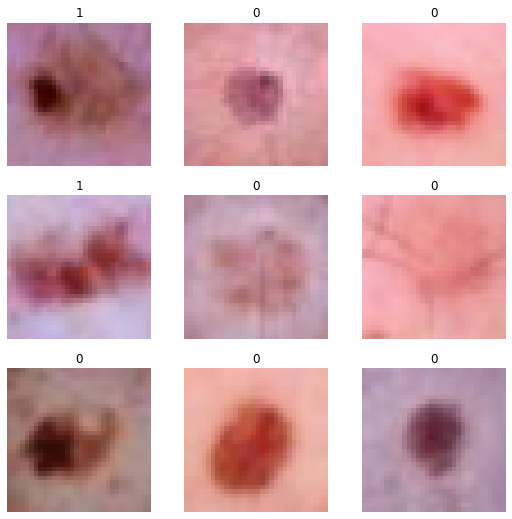

In [19]:
dls_aug.show_batch()

In [30]:
learn = cnn_learner(dls_aug, resnet34, metrics=error_rate)


SuggestedLRs(lr_min=0.012022644281387329, lr_steep=6.309573450380412e-07)

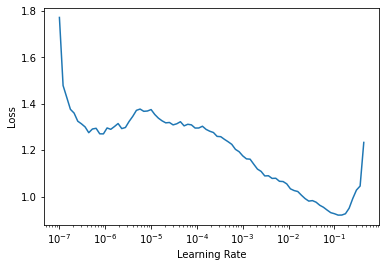

In [31]:
learn.lr_find()


In [32]:
lr = 0.1

learn.fit_one_cycle(5, slice(lr))


epoch,train_loss,valid_loss,error_rate,time
0,1.137361,15.524875,0.550000,00:00
1,1.865344,6.870158,0.375000,00:00
2,2.039989,8.864294,0.250000,00:00
3,1.969149,7.252105,0.350000,00:00
4,1.928474,5.772317,0.300000,00:00


In [33]:
learn.fit_one_cycle(5, slice(lr))


epoch,train_loss,valid_loss,error_rate,time
0,2.238825,4.997379,0.375000,00:00
1,2.289570,3.394469,0.325000,00:00
2,2.100683,4.780074,0.400000,00:00
3,1.837741,4.670833,0.375000,00:00
4,1.685259,3.756935,0.375000,00:00


In [34]:
learn.unfreeze()


SuggestedLRs(lr_min=0.001096478197723627, lr_steep=1.0964781722577754e-06)

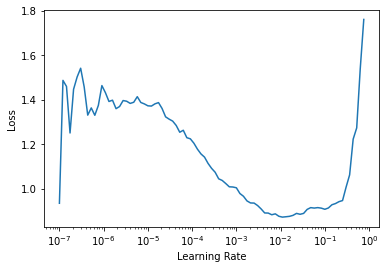

In [35]:
learn.lr_find()

In [36]:

learn.fit_one_cycle(5, slice(3e-6, lr/5))


epoch,train_loss,valid_loss,error_rate,time
0,0.940438,3.071808,0.400000,00:00
1,1.035278,2.391886,0.250000,00:00
2,1.055366,2.857996,0.250000,00:00
3,0.999539,3.636337,0.275000,00:00
4,1.092296,3.995049,0.275000,00:00


In [37]:
learn.fit_one_cycle(20, slice(3e-6, lr/5))


epoch,train_loss,valid_loss,error_rate,time
0,1.417970,4.228349,0.275000,00:00
1,1.070969,4.169873,0.300000,00:00
2,0.927156,4.442315,0.300000,00:00
3,0.896741,4.649290,0.325000,00:00
4,0.783363,4.720419,0.325000,00:00
5,0.732385,4.545812,0.300000,00:00
6,0.728618,4.584867,0.275000,00:00
7,0.718939,4.239924,0.250000,00:00
8,0.729759,3.741149,0.300000,00:00
9,0.716554,2.617474,0.375000,00:00


In [38]:
learn.fit_one_cycle(10, slice(3e-6, lr/5))


epoch,train_loss,valid_loss,error_rate,time
0,0.305808,1.125229,0.275000,00:00
1,0.295282,1.101796,0.275000,00:00
2,0.244472,1.027804,0.275000,00:00
3,0.246132,1.101199,0.275000,00:00
4,0.278228,1.340287,0.275000,00:00
5,0.275888,1.200988,0.300000,00:00
6,0.297790,1.033825,0.275000,00:00
7,0.270336,0.969526,0.275000,00:00
8,0.257995,0.922766,0.250000,00:00
9,0.249865,0.942109,0.275000,00:00


SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.00363078061491251)

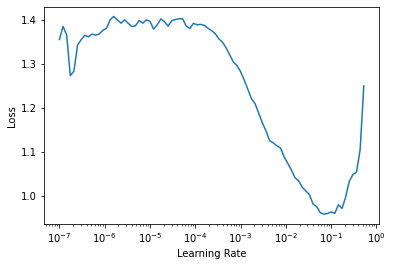

In [40]:
#let "fine_tune" handle finding the learning rate and unfreezing for us. 

learn = cnn_learner(dls_aug, resnet18, metrics=error_rate)
learn.lr_find()

In [41]:
learn.fine_tune(4, 1e-3, freeze_epochs=1)

epoch,train_loss,valid_loss,error_rate,time
0,1.309612,1.075051,0.800000,00:00


epoch,train_loss,valid_loss,error_rate,time
0,1.392128,0.973616,0.650000,00:00
1,1.293713,0.816138,0.550000,00:00
2,1.193959,0.733325,0.475000,00:00
3,1.149511,0.689731,0.475000,00:00


In [42]:
learn.fine_tune(10, 1e-3, freeze_epochs=1)

epoch,train_loss,valid_loss,error_rate,time
0,0.939528,0.650500,0.350000,00:00


epoch,train_loss,valid_loss,error_rate,time
0,0.752863,0.617458,0.325000,00:00
1,0.771099,0.567391,0.300000,00:00
2,0.818012,0.517706,0.225000,00:00
3,0.855438,0.503254,0.225000,00:00
4,0.804947,0.491278,0.200000,00:00
5,0.793594,0.491161,0.200000,00:00
6,0.753763,0.467399,0.175000,00:00
7,0.724516,0.479461,0.200000,00:00
8,0.716597,0.471296,0.200000,00:00
9,0.699876,0.467979,0.200000,00:00


In [43]:
learn.fine_tune(10, 1e-3, freeze_epochs=1)

epoch,train_loss,valid_loss,error_rate,time
0,0.710829,0.471844,0.225000,00:00


epoch,train_loss,valid_loss,error_rate,time
0,0.664523,0.504003,0.225000,00:00
1,0.672916,0.532772,0.225000,00:00
2,0.631536,0.474776,0.225000,00:00
3,0.616167,0.474932,0.175000,00:00
4,0.624394,0.479712,0.200000,00:00
5,0.642857,0.512335,0.200000,00:00
6,0.622759,0.554077,0.225000,00:00
7,0.603494,0.565570,0.225000,00:00
8,0.601153,0.628113,0.250000,00:00
9,0.587116,0.661052,0.250000,00:00


In [4]:
#this never works. 
from migrating_pytorch import *

ModuleNotFoundError: No module named 'migrating_pytorch'

In [ ]:
### Less Augmentation

In [65]:
a_tfms2 = aug_transforms(flip_vert=True, max_lighting=0, max_zoom=1.00, max_warp=0., size=32)

In [66]:
dls_aug2 = ImageDataLoaders.from_name_re(path, files, r'\w+_([01]).jpg', batch_tfms=a_tfms2) 

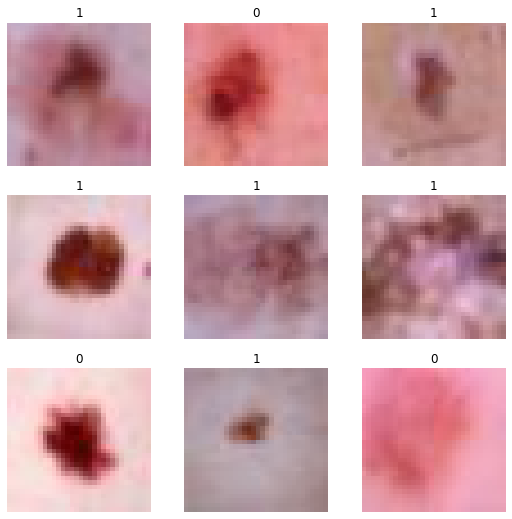

In [67]:
dls_aug2.show_batch()

In [68]:
learn = cnn_learner(dls_aug2, resnet18, metrics=error_rate)


SuggestedLRs(lr_min=0.012022644281387329, lr_steep=6.309573450380412e-07)

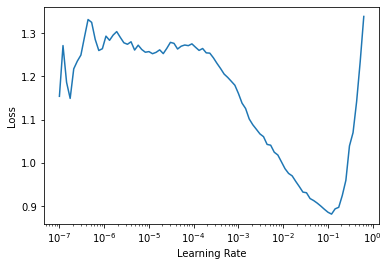

In [69]:
learn.lr_find()

In [70]:
learn.fine_tune(25, 1e-3, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,1.354895,0.879052,0.525000,00:00
1,1.231988,0.813584,0.575000,00:00
2,1.182071,0.704337,0.450000,00:00


epoch,train_loss,valid_loss,error_rate,time
0,1.038535,0.639508,0.350000,00:00
1,1.003959,0.584580,0.300000,00:00
2,0.936806,0.546366,0.250000,00:00
3,0.910298,0.496243,0.200000,00:00
4,0.850636,0.452768,0.200000,00:00
5,0.840784,0.438613,0.175000,00:00
6,0.799842,0.443978,0.200000,00:00
7,0.760042,0.457592,0.175000,00:00
8,0.758324,0.466476,0.175000,00:00
9,0.723561,0.489171,0.150000,00:00


In [71]:
learn.save('rn18-1')

Path('data/MelanomaDetection/labeled/models/rn18-1.pth')